In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Raw data from twitter reddit and from around the web
raw_data = pd.read_csv('huge_dataset.csv')

# Pre-trained Embeddings
EMBEDDING_FILE = f'glove.6B.100d.txt'

raw_data.head(-10)
# 270K rows

,Unnamed: 0,Text,Emotion
0,0,That game hurt.,sadness
1,1,"You do right, if you don't care then fuck 'em!",neutral
2,2,Man I love reddit.,love
3,3,"[NAME] was nowhere near them, he was by the Fa...",neutral
4,4,Right? Considering it’s such an important docu...,happy
...,...,...,...
269258,269258,"Effortlessly , his knee slid to part her legs ...",fear
269259,269259,The commercial ethic meant some deterioration ...,fear
269260,269260,This caused a good deal of consternation and d...,fear
269261,269261,And it was equally insistent that a policy of ...,fear


C:\ProgramData\Anaconda3\envs\Dsci\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Emotion', ylabel='count'>

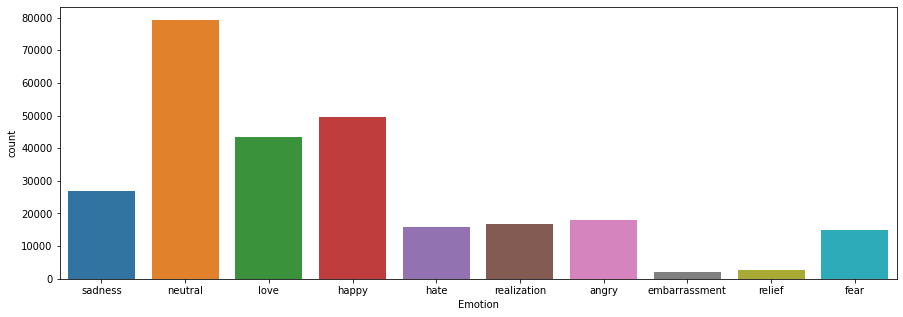

In [24]:
# Target Classes (Labels)
plt.figure(figsize=(15,5))

sns.countplot(raw_data['Emotion'])

In [25]:
# Drop columns with NA values
raw_data = raw_data.dropna() 

X = raw_data.drop('Emotion', axis=1) #input
y = raw_data['Emotion'] #output

messages = X.copy()
# Reset index after droping null columns
messages.reset_index(inplace=True)

In [5]:
nltk.download('stopwords')
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elusive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Preparing the corpus (cleaning the data)
corpus = []
for i in tqdm(range(0, len(messages))):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i]) #Remove Special Characters
    review = review.lower() #Lower case 
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #Remove stopwords
    review = ' '.join(review)
    corpus.append(review)

100%|██████████| 269273/269273 [09:23<00:00, 477.65it/s]


In [8]:
# Saving Progress
if len(corpus) > 100000:
    corpus_df = pd.DataFrame({'Text': corpus})
    corpus_df.to_csv('large_corpus.csv')
print(len(corpus))
corpus[-10:]

269273


['edouard look felt sicken dism',
 'tina children move school cecilia felt dismay guilti reli',
 'felt dismay sorrow mani peopl countri share person good fortun',
 'stare one anoth dismay sad small wicked friend neighbour strewn around mind like dirti confetti parti long pa',
 'cleo stare content dism',
 'melissa stare friend dism',
 'success state elect seen govern parti pummel dismay electora',
 'vincent irrit dismay',
 'kendal hume turn back face dismay coup',
 'dismay surpri']

In [6]:
# Loading Progress
temp = pd.read_csv('large_corpus.csv')
temp['Emotion'] = raw_data['Emotion'].values
temp['Text'] = temp['Text'].str.replace('\d+', '')
temp = temp.dropna()

<ipython-input-6-c311ee3e5c78>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  temp['Text'] = temp['Text'].str.replace('\d+', '')


In [26]:
temp_list = temp['Text'].tolist()
print(len(temp_list))
print(temp.shape)
temp_list[-10:]

268737
(268737, 3)


['edouard look felt sicken dism',
 'tina children move school cecilia felt dismay guilti reli',
 'felt dismay sorrow mani peopl countri share person good fortun',
 'stare one anoth dismay sad small wicked friend neighbour strewn around mind like dirti confetti parti long pa',
 'cleo stare content dism',
 'melissa stare friend dism',
 'success state elect seen govern parti pummel dismay electora',
 'vincent irrit dismay',
 'kendal hume turn back face dismay coup',
 'dismay surpri']

In [27]:
X = temp.drop('Emotion', axis=1) #input
y = temp['Emotion'] #output

In [28]:
corpus = []
corpus = temp_list
print(len(corpus))
corpus[-10:]

268737


['edouard look felt sicken dism',
 'tina children move school cecilia felt dismay guilti reli',
 'felt dismay sorrow mani peopl countri share person good fortun',
 'stare one anoth dismay sad small wicked friend neighbour strewn around mind like dirti confetti parti long pa',
 'cleo stare content dism',
 'melissa stare friend dism',
 'success state elect seen govern parti pummel dismay electora',
 'vincent irrit dismay',
 'kendal hume turn back face dismay coup',
 'dismay surpri']

In [10]:
# Creating the dictionary with word as key and pretrained-value array as value
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))


# Calculate MEAN and Standard-Deviation for the pre-trained weights
all_embeddings = np.stack(embeddings_index.values())
embedding_mean, embedding_std = all_embeddings.mean(), all_embeddings.std()
print(embedding_mean, embedding_std)

C:\ProgramData\Anaconda3\envs\Dsci\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
0.004451992 0.4081574


In [12]:
vocabulary_size = 30000
# Word vector size
embed_size = 100 

tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(list(corpus))

In [13]:
word_index = tokenizer.word_index #total words in the corpus
nb_words = min(vocabulary_size, len(word_index))

In [14]:
# Initialize weight matrix for embedding layer
embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_words, embed_size)) 

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue #skip the words if vocab size is reached
    embedding_vector = embeddings_index.get(word) #extracting the pre-trained values from GloVe
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
# Contains the pretrained GloVe weights for the words
len(embedding_matrix)

30000

In [16]:
# One hot representation for input
onehot_repr = [one_hot(words, vocabulary_size) for words in corpus]

# Finding max words
l = 0
for x in tqdm(corpus):
    l = max(l, len(x.split(' ')))

#Padding the sequences for input
sentence_length = l
embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sentence_length)
print(embedded_docs)

100%|██████████| 268737/268737 [00:00<00:00, 1437656.86it/s]
[[    0     0     0 ...     0  6930 18494]
 [    0     0     0 ... 28498  1654 11946]
 [    0     0     0 ... 24844   682  2157]
 ...
 [    0     0     0 ...  2107 25962  4438]
 [    0     0     0 ... 25216  4438  2225]
 [    0     0     0 ...     0  4438 25336]]


In [29]:
# Encoding the target outputs to integers
label_encoder = preprocessing.LabelEncoder()

X_final = np.array(embedded_docs) #input to array
y = label_encoder.fit_transform(y)
y_final = np.array(y)
print(y_final)

X_final.shape, y_final.shape

[9 6 5 ... 2 2 2]


((268737, 35), (268737,))

In [30]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.2, random_state = 42)

# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 21)

In [31]:
# Creating model
model = Sequential()
model.add(Embedding(vocabulary_size, embed_size, weights=[embedding_matrix]))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L1(0.02), activity_regularizer = tf.keras.regularizers.L2(0.02))) # L1 and L2 regularization
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         3000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [32]:
model_save = ModelCheckpoint('large_weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', mode = 'min', verbose = 1)

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 40, batch_size = 64, callbacks = [model_save])

Epoch 1/40
2688/2688 [==============================] - 78s 28ms/step - loss: 2.3428 - accuracy: 0.2939 - val_loss: 1.9586 - val_accuracy: 0.3508

Epoch 00001: val_loss improved from inf to 1.95856, saving model to large_weights.h5
Epoch 2/40
2688/2688 [==============================] - 75s 28ms/step - loss: 1.9255 - accuracy: 0.3719 - val_loss: 1.8803 - val_accuracy: 0.3851

Epoch 00002: val_loss improved from 1.95856 to 1.88030, saving model to large_weights.h5
Epoch 3/40
2688/2688 [==============================] - 76s 28ms/step - loss: 1.8709 - accuracy: 0.3859 - val_loss: 1.8045 - val_accuracy: 0.4216

Epoch 00003: val_loss improved from 1.88030 to 1.80446, saving model to large_weights.h5
Epoch 4/40
2688/2688 [==============================] - 75s 28ms/step - loss: 1.7912 - accuracy: 0.4362 - val_loss: 1.7482 - val_accuracy: 0.4605

Epoch 00004: val_loss improved from 1.80446 to 1.74820, saving model to large_weights.h5
Epoch 5/40
2688/2688 [==============================] - 76s 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


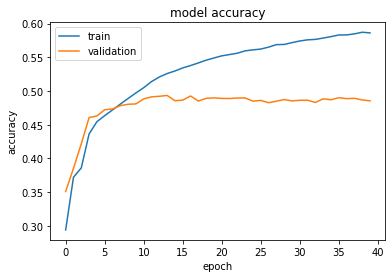

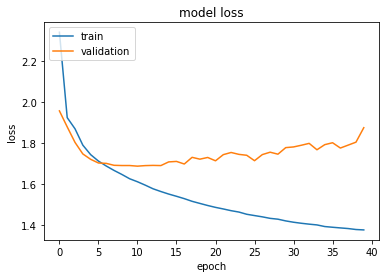

In [33]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [34]:
#Load the best weights
model.load_weights('large_weights.h5')

In [35]:
y_pred = model.predict_classes(X_test)
print(y_pred)

C:\ProgramData\Anaconda3\envs\Dsci\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
[6 6 6 ... 6 6 6]


In [36]:
# Accuracy score
print(accuracy_score(y_test,y_pred))

0.4839994046290095


In [37]:
# Classification report
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.40401   0.24368   0.30400      3558
           1    0.00000   0.00000   0.00000       398
           2    0.45624   0.17787   0.25596      3019
           3    0.57508   0.62195   0.59760     10086
           4    0.00000   0.00000   0.00000      3211
           5    0.55052   0.36750   0.44077      8555
           6    0.43072   0.79819   0.55952     15812
           7    0.00000   0.00000   0.00000      3245
           8    0.00000   0.00000   0.00000       578
           9    0.57105   0.48657   0.52543      5286

    accuracy                        0.48400     53748
   macro avg    0.29876   0.26958   0.26833     53748
weighted avg    0.43079   0.48400   0.43308     53748

C:\ProgramData\Anaconda3\envs\Dsci\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)


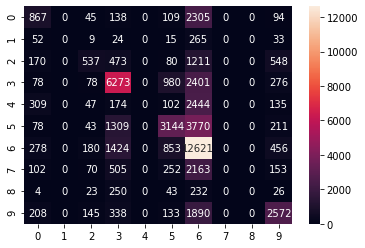

In [38]:
#Confusion Matrix
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = "d"))

In [39]:
#Mapping of target classes using label-encoder
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

emotional_class_mapping = []
for item in le_name_mapping.items():
    # print(key)
    emotional_class_mapping.append(item[0])

print(emotional_class_mapping)

{'angry': 0, 'embarrassment': 1, 'fear': 2, 'happy': 3, 'hate': 4, 'love': 5, 'neutral': 6, 'realization': 7, 'relief': 8, 'sadness': 9}
['angry', 'embarrassment', 'fear', 'happy', 'hate', 'love', 'neutral', 'realization', 'relief', 'sadness']


In [40]:
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    onehot_repr = [one_hot(review, vocabulary_size)] 
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sentence_length)
    predicti = model.predict(embed)
    return emotional_class_mapping[np.argmax(predicti)]

In [41]:
predict_emotion('I am very happy and joyful today')

'happy'

In [42]:
predict_emotion('He is an arrogant and rude person')

'angry'

In [43]:
predict_emotion('I feel depressed')

'sadness'

In [44]:
predict_emotion('I am nervous about my final tomorrow')

'fear'

In [46]:
predict_emotion('I am quite furious')

'neutral'

In [47]:
predict_emotion('Oh gosh that is finally over')

'happy'

In [48]:
predict_emotion('I cant live without her')

'neutral'

In [49]:
predict_emotion('She means the world to me')

'neutral'

In [50]:
predict_emotion('I love my mom')

'love'